In [1]:
import matplotlib.animation as animation
from datetime import datetime

import furniture_bench
from furniture_bench.envs.observation import DEFAULT_STATE_OBS

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import random
import math

import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
from diffusers.training_utils import EMAModel
from diffusers.optimization import get_scheduler

import wandb

import zarr
from glob import glob
import pickle

device = torch.device("cuda")

Importing module 'gym_38' (/home/larsankile/isaacgym/python/isaacgym/_bindings/linux-x86_64/gym_38.so)
Setting GYM_USD_PLUG_INFO_PATH to /home/larsankile/isaacgym/python/isaacgym/_bindings/linux-x86_64/usd/plugInfo.json


/home/larsankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
env = gym.make(
    "FurnitureSim-v0",
    furniture="one_leg",  # Specifies the type of furniture [lamp | square_table | desk | drawer | cabinet | round_table | stool | chair | one_leg].
    num_envs=1,  # Number of parallel environments.
    resize_img=True,  # If true, images are resized to 224 x 224.
    concat_robot_state=True,  # If true, robot state is concatenated to the observation.
    obs_keys=DEFAULT_STATE_OBS
    + ["color_image1", "color_image2"],  # Specifies the observation keys.
    headless=True,  # If true, simulation runs without GUI.
    compute_device_id=0,  # GPU device ID for simulation.
    graphics_device_id=0,  # GPU device ID for rendering.
    init_assembled=False,  # If true, the environment is initialized with assembled furniture.
    np_step_out=False,  # If true, env.step() returns Numpy arrays.
    channel_first=False,  # If true, images are returned in channel first format.
    randomness="low",  # Level of randomness in the environment [low | med | high].
    high_random_idx=-1,  # Index of the high randomness level (range: [0-2]). Default -1 will randomly select the index within the range.
    save_camera_input=False,  # If true, the initial camera inputs are saved.
    record=False,  # If true, videos of the wrist and front cameras' RGB inputs are recorded.
    max_env_steps=3000,  # Maximum number of steps per episode.
    act_rot_repr="quat",  # Representation of rotation for action space. Options are 'quat' and 'axis'.
)

PyTorch version 2.0.1+cu117
Device count 2
/home/larsankile/isaacgym/python/isaacgym/_bindings/src/gymtorch


Using /home/larsankile/.cache/torch_extensions/py38_cu117 as PyTorch extensions root...
Emitting ninja build file /home/larsankile/.cache/torch_extensions/py38_cu117/gymtorch/build.ninja...
Building extension module gymtorch...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


ninja: no work to do.


Loading extension module gymtorch...


Not connected to PVD
+++ Using GPU PhysX
Physics Engine: PhysX
Physics Device: cuda:0
GPU Pipeline: enabled
Using SDF cache directory '/home/larsankile/.isaacgym/sdf_V100'
~!~!~! Loaded/Cooked SDF triangle mesh 0 @ 0x84d82870, resolution=512, spacing=0.000317
  ~!~! Bounds:  (-0.081250, 0.081250) (-0.015685, 0.015565) (-0.081250, 0.081251)
  ~!~! Extents: (0.162500, 0.031250, 0.162501)
  ~!~! Resolution: (512, 99, 512)
~!~!~! Loaded/Cooked SDF triangle mesh 1 @ 0x84ec2ed0, resolution=512, spacing=0.000171
  ~!~! Bounds:  (-0.015000, 0.015000) (-0.056250, 0.031250) (-0.014383, 0.015618)
  ~!~! Extents: (0.030000, 0.087500, 0.030001)
  ~!~! Resolution: (176, 512, 176)
~!~!~! Loaded/Cooked SDF triangle mesh 2 @ 0x856b0690, resolution=512, spacing=0.000172
  ~!~! Bounds:  (-0.015000, 0.015000) (-0.056562, 0.031376) (-0.015438, 0.014563)
  ~!~! Extents: (0.030000, 0.087938, 0.030001)
  ~!~! Resolution: (175, 512, 175)
~!~!~! Loaded/Cooked SDF triangle mesh 3 @ 0x85a26e70, resolution=512, sp

In [3]:
# 1. seed env for initial state.
# Seed 0-200 are used for the demonstration dataset.
env.seed(1000)

# 2. must reset before use
obs = env.reset()

# 3.
action = env.action_space.sample()

# 4. Standard gym step method
obs, reward, done, info = env.step(action)

robot_state_dim = obs["robot_state"].shape[1]
parts_poses_state_dim = obs["parts_poses"].shape[1]
obs_dim = robot_state_dim + parts_poses_state_dim
action_dim = action.shape[1]

# prints and explains each dimension of the observation and action vectors
with np.printoptions(precision=4, suppress=True, threshold=5):
    print(
        f"Robot state dim: {robot_state_dim}, Parts poses state dim: {parts_poses_state_dim}, Total obs dim: {obs_dim}, Action dim: {action_dim}"
    )
    print("Obs: ", repr(obs))
    print("Action: ", repr(action))

INFO: Found collision-free init pose


Robot state dim: 14, Parts poses state dim: 35, Total obs dim: 49, Action dim: 8
Obs:  {'robot_state': tensor([[ 0.5790,  0.0578,  0.1075, -0.8936, -0.4488,  0.0110,  0.0025,  0.1218,
          0.0292, -0.6061,  0.1356,  0.6743, -0.0628,  0.0612]],
       device='cuda:0'), 'parts_poses': tensor([[-0.0132,  0.2427, -0.0157, -0.0587, -0.7047,  0.7047,  0.0587, -0.1958,
          0.0772, -0.0150,  0.0616, -0.7044,  0.0616,  0.7044, -0.1125,  0.0702,
         -0.0150, -0.0845, -0.7020, -0.0845,  0.7020,  0.1134,  0.0798, -0.0150,
         -0.0117, -0.7070, -0.0117,  0.7070,  0.2092,  0.0772, -0.0150,  0.0134,
         -0.7070,  0.0134,  0.7070]], device='cuda:0'), 'color_image1': tensor([[[[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [ 84,  84,  84],
          [ 84,  84,  84],
          [114, 114, 114]],

         [[255, 255, 255],
          [255, 255, 255],
          [255, 255, 255],
          ...,
          [114, 114, 114],
          [11

## Preprocess the data

In [4]:
file_paths = glob("scripted_sim_demo_state/**/*.pkl", recursive=True)
n_state_action_pairs = len(file_paths)

observations = []
actions = []
episode_ends = []

end_index = 0
for path in tqdm(file_paths):
    with open(path, "rb") as f:
        data = pickle.load(f)

    for obs, action in zip(data["observations"], data["actions"]):
        # Each observation is just a concatenation of the robot state and the object state.
        # Collect the robot state.
        robot_state = obs["robot_state"]
        parts_poses = obs["parts_poses"]

        # Add the observation to the overall list.
        observation = np.concatenate((robot_state, parts_poses))
        observations.append(observation)

        # Add the action to the overall list.
        actions.append(action)

        # Increment the end index.
        end_index += 1

    # Add the end index to the overall list.
    episode_ends.append(end_index)

# Convert the lists to numpy arrays.
observations = np.array(observations)
actions = np.array(actions)
episode_ends = np.array(episode_ends)

# Save the data to a zarr file.
zarr.save(
    "demos.zarr", observations=observations, actions=actions, episode_ends=episode_ends
)

100%|██████████| 197/197 [00:00<00:00, 330.49it/s]


In [5]:
dataset_root = zarr.open("demos.zarr", mode="r")

dataset_root["observations"].shape, dataset_root["actions"].shape, dataset_root[
    "episode_ends"
].shape

((95874, 49), (95874, 8), (197,))

In [6]:
dataset_root["observations"].shape[0] / dataset_root["episode_ends"].shape[0]

486.6700507614213

In [7]:
episode_ends = dataset_root["episode_ends"][:]
episode_ends

array([  475,   946,  1439,  1953,  2458,  2973,  3444,  3923,  4409,
        4858,  5302,  5826,  6307,  6783,  7273,  7791,  8312,  8797,
        9277,  9785, 10296, 10834, 11304, 11828, 12308, 12772, 13284,
       13751, 14240, 14726, 15232, 15670, 16256, 16709, 17182, 17728,
       18196, 18719, 19168, 19637, 20106, 20564, 21032, 21565, 22051,
       22519, 22982, 23439, 23929, 24384, 24839, 25310, 25843, 26360,
       26819, 27299, 27762, 28228, 28709, 29228, 29753, 30235, 30709,
       31194, 31695, 32224, 32699, 33231, 33731, 34246, 34711, 35182,
       35694, 36146, 36633, 37110, 37644, 38116, 38659, 39146, 39606,
       40071, 40558, 41082, 41541, 42024, 42479, 42908, 43398, 43838,
       44371, 44895, 45351, 45832, 46309, 46765, 47236, 47751, 48277,
       48754, 49232, 49698, 50235, 50751, 51210, 51734, 52296, 52749,
       53277, 53753, 54210, 54681, 55138, 55605, 56058, 56583, 57061,
       57610, 58083, 58559, 59016, 59488, 60014, 60474, 60958, 61427,
       61896, 62371,

## Make dataset for training

In [8]:
def create_sample_indices(
    episode_ends: np.ndarray,
    sequence_length: int,
    pad_before: int = 0,
    pad_after: int = 0,
):
    indices = list()
    for i in range(len(episode_ends)):
        start_idx = 0
        if i > 0:
            start_idx = episode_ends[i - 1]
        end_idx = episode_ends[i]
        episode_length = end_idx - start_idx

        min_start = -pad_before
        max_start = episode_length - sequence_length + pad_after

        # range stops one idx before end
        for idx in range(min_start, max_start + 1):
            buffer_start_idx = max(idx, 0) + start_idx
            buffer_end_idx = min(idx + sequence_length, episode_length) + start_idx
            start_offset = buffer_start_idx - (idx + start_idx)
            end_offset = (idx + sequence_length + start_idx) - buffer_end_idx
            sample_start_idx = 0 + start_offset
            sample_end_idx = sequence_length - end_offset
            indices.append(
                [buffer_start_idx, buffer_end_idx, sample_start_idx, sample_end_idx]
            )
    indices = np.array(indices)
    return indices


def sample_sequence(
    train_data,
    sequence_length,
    buffer_start_idx,
    buffer_end_idx,
    sample_start_idx,
    sample_end_idx,
):
    result = dict()
    for key, input_arr in train_data.items():
        sample = input_arr[buffer_start_idx:buffer_end_idx]
        data = sample
        if (sample_start_idx > 0) or (sample_end_idx < sequence_length):
            data = np.zeros(
                shape=(sequence_length,) + input_arr.shape[1:], dtype=input_arr.dtype
            )
            if sample_start_idx > 0:
                data[:sample_start_idx] = sample[0]
            if sample_end_idx < sequence_length:
                data[sample_end_idx:] = sample[-1]
            data[sample_start_idx:sample_end_idx] = sample
        result[key] = data
    return result


# normalize data
def get_data_stats(data):
    data = data.reshape(-1, data.shape[-1])
    stats = {"min": np.min(data, axis=0), "max": np.max(data, axis=0)}
    return stats


def normalize_data(data, stats):
    # nomalize to [0,1]
    ndata = (data - stats["min"]) / (stats["max"] - stats["min"])
    # normalize to [-1, 1]
    ndata = ndata * 2 - 1
    return ndata


def unnormalize_data(ndata, stats):
    ndata = (ndata + 1) / 2
    data = ndata * (stats["max"] - stats["min"]) + stats["min"]
    return data


# dataset
class OneLegStateDataset(torch.utils.data.Dataset):
    def __init__(self, dataset_path, pred_horizon, obs_horizon, action_horizon):
        # read from zarr dataset
        dataset = zarr.open(dataset_path, "r")
        # All demonstration episodes are concatinated in the first dimension N
        train_data = {
            # (N, action_dim)
            "action": dataset["actions"][:],
            # (N, obs_dim)
            "obs": dataset["observations"][:],
        }
        # Marks one-past the last index for each episode
        episode_ends = dataset["episode_ends"][:]

        # compute start and end of each state-action sequence
        # also handles padding
        indices = create_sample_indices(
            episode_ends=episode_ends,
            sequence_length=pred_horizon,
            # add padding such that each timestep in the dataset are seen
            pad_before=obs_horizon - 1,
            pad_after=action_horizon - 1,
        )

        # compute statistics and normalized data to [-1,1]
        stats = dict()
        normalized_train_data = dict()
        for key, data in train_data.items():
            stats[key] = get_data_stats(data)
            normalized_train_data[key] = normalize_data(data, stats[key])

        self.indices = indices
        self.stats = stats
        self.normalized_train_data = normalized_train_data
        self.pred_horizon = pred_horizon
        self.action_horizon = action_horizon
        self.obs_horizon = obs_horizon

    def __len__(self):
        # all possible segments of the dataset
        return len(self.indices)

    def __getitem__(self, idx):
        # get the start/end indices for this datapoint
        (
            buffer_start_idx,
            buffer_end_idx,
            sample_start_idx,
            sample_end_idx,
        ) = self.indices[idx]

        # get normalized data using these indices
        nsample = sample_sequence(
            train_data=self.normalized_train_data,
            sequence_length=self.pred_horizon,
            buffer_start_idx=buffer_start_idx,
            buffer_end_idx=buffer_end_idx,
            sample_start_idx=sample_start_idx,
            sample_end_idx=sample_end_idx,
        )

        # discard unused observations
        nsample["obs"] = nsample["obs"][: self.obs_horizon, :]
        return nsample

## Define the model

In [9]:
from typing import Union


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class Downsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.Conv1d(dim, dim, 3, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Upsample1d(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.conv = nn.ConvTranspose1d(dim, dim, 4, 2, 1)

    def forward(self, x):
        return self.conv(x)


class Conv1dBlock(nn.Module):
    """
    Conv1d --> GroupNorm --> Mish
    """

    def __init__(self, inp_channels, out_channels, kernel_size, n_groups=8):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv1d(
                inp_channels, out_channels, kernel_size, padding=kernel_size // 2
            ),
            nn.GroupNorm(n_groups, out_channels),
            nn.Mish(),
        )

    def forward(self, x):
        return self.block(x)


class ConditionalResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, cond_dim, kernel_size=3, n_groups=8):
        super().__init__()

        self.blocks = nn.ModuleList(
            [
                Conv1dBlock(in_channels, out_channels, kernel_size, n_groups=n_groups),
                Conv1dBlock(out_channels, out_channels, kernel_size, n_groups=n_groups),
            ]
        )

        # FiLM modulation https://arxiv.org/abs/1709.07871
        # predicts per-channel scale and bias
        cond_channels = out_channels * 2
        self.out_channels = out_channels
        self.cond_encoder = nn.Sequential(
            nn.Mish(), nn.Linear(cond_dim, cond_channels), nn.Unflatten(-1, (-1, 1))
        )

        # make sure dimensions compatible
        self.residual_conv = (
            nn.Conv1d(in_channels, out_channels, 1)
            if in_channels != out_channels
            else nn.Identity()
        )

    def forward(self, x, cond):
        """
        x : [ batch_size x in_channels x horizon ]
        cond : [ batch_size x cond_dim]

        returns:
        out : [ batch_size x out_channels x horizon ]
        """
        out = self.blocks[0](x)
        embed = self.cond_encoder(cond)

        embed = embed.reshape(embed.shape[0], 2, self.out_channels, 1)
        scale = embed[:, 0, ...]
        bias = embed[:, 1, ...]
        out = scale * out + bias

        out = self.blocks[1](out)
        out = out + self.residual_conv(x)
        return out


class ConditionalUnet1D(nn.Module):
    def __init__(
        self,
        input_dim,
        global_cond_dim,
        diffusion_step_embed_dim=256,
        down_dims=[256, 512, 1024],
        kernel_size=5,
        n_groups=8,
    ):
        """
        input_dim: Dim of actions.
        global_cond_dim: Dim of global conditioning applied with FiLM
          in addition to diffusion step embedding. This is usually obs_horizon * obs_dim
        diffusion_step_embed_dim: Size of positional encoding for diffusion iteration k
        down_dims: Channel size for each UNet level.
          The length of this array determines numebr of levels.
        kernel_size: Conv kernel size
        n_groups: Number of groups for GroupNorm
        """

        super().__init__()
        all_dims = [input_dim] + list(down_dims)
        start_dim = down_dims[0]

        dsed = diffusion_step_embed_dim
        diffusion_step_encoder = nn.Sequential(
            SinusoidalPosEmb(dsed),
            nn.Linear(dsed, dsed * 4),
            nn.Mish(),
            nn.Linear(dsed * 4, dsed),
        )
        cond_dim = dsed + global_cond_dim

        in_out = list(zip(all_dims[:-1], all_dims[1:]))
        mid_dim = all_dims[-1]
        self.mid_modules = nn.ModuleList(
            [
                ConditionalResidualBlock1D(
                    mid_dim,
                    mid_dim,
                    cond_dim=cond_dim,
                    kernel_size=kernel_size,
                    n_groups=n_groups,
                ),
                ConditionalResidualBlock1D(
                    mid_dim,
                    mid_dim,
                    cond_dim=cond_dim,
                    kernel_size=kernel_size,
                    n_groups=n_groups,
                ),
            ]
        )

        down_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (len(in_out) - 1)
            down_modules.append(
                nn.ModuleList(
                    [
                        ConditionalResidualBlock1D(
                            dim_in,
                            dim_out,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        ConditionalResidualBlock1D(
                            dim_out,
                            dim_out,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        Downsample1d(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        up_modules = nn.ModuleList([])
        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (len(in_out) - 1)
            up_modules.append(
                nn.ModuleList(
                    [
                        ConditionalResidualBlock1D(
                            dim_out * 2,
                            dim_in,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        ConditionalResidualBlock1D(
                            dim_in,
                            dim_in,
                            cond_dim=cond_dim,
                            kernel_size=kernel_size,
                            n_groups=n_groups,
                        ),
                        Upsample1d(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        final_conv = nn.Sequential(
            Conv1dBlock(start_dim, start_dim, kernel_size=kernel_size),
            nn.Conv1d(start_dim, input_dim, 1),
        )

        self.diffusion_step_encoder = diffusion_step_encoder
        self.up_modules = up_modules
        self.down_modules = down_modules
        self.final_conv = final_conv

        print(
            "number of parameters: {:e}".format(
                sum(p.numel() for p in self.parameters())
            )
        )

    def forward(
        self,
        sample: torch.Tensor,
        timestep: Union[torch.Tensor, float, int],
        global_cond=None,
    ):
        """
        x: (B,T,input_dim)
        timestep: (B,) or int, diffusion step
        global_cond: (B,global_cond_dim)
        output: (B,T,input_dim)
        """
        # (B,T,C)
        sample = sample.moveaxis(-1, -2)
        # (B,C,T)

        # 1. time
        timesteps = timestep
        if not torch.is_tensor(timesteps):
            # TODO: this requires sync between CPU and GPU. So try to pass timesteps as tensors if you can
            timesteps = torch.tensor(
                [timesteps], dtype=torch.long, device=sample.device
            )
        elif torch.is_tensor(timesteps) and len(timesteps.shape) == 0:
            timesteps = timesteps[None].to(sample.device)
        # broadcast to batch dimension in a way that's compatible with ONNX/Core ML
        timesteps = timesteps.expand(sample.shape[0])

        global_feature = self.diffusion_step_encoder(timesteps)

        if global_cond is not None:
            global_feature = torch.cat([global_feature, global_cond], axis=-1)

        x = sample
        h = []
        for idx, (resnet, resnet2, downsample) in enumerate(self.down_modules):
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            h.append(x)
            x = downsample(x)

        for mid_module in self.mid_modules:
            x = mid_module(x, global_feature)

        for idx, (resnet, resnet2, upsample) in enumerate(self.up_modules):
            x = torch.cat((x, h.pop()), dim=1)
            x = resnet(x, global_feature)
            x = resnet2(x, global_feature)
            x = upsample(x)

        x = self.final_conv(x)

        # (B,C,T)
        x = x.moveaxis(-1, -2)
        # (B,T,C)
        return x

## Train the Damn Thing

In [10]:
# use a seed >200 to avoid initial states seen in the training dataset
import collections


def rollout(
    env,
    noise_pred_net,
    noise_scheduler,
    stats,
    config,
):
    max_steps = 500
    env.seed(10_000)

    # get first observation
    obs = env.reset()

    # keep a queue of last 2 steps of observations
    obs_deque = collections.deque(
        [torch.cat([obs["robot_state"], obs["parts_poses"]], dim=-1).cpu()]
        * config.obs_horizon,
        maxlen=config.obs_horizon,
    )
    # save visualization and rewards
    imgs1 = [obs["color_image1"]]
    imgs2 = [obs["color_image2"]]
    rewards = list()
    done = False
    step_idx = 0

    with tqdm(total=max_steps, desc="Eval OneLeg State Env") as pbar:
        while not done:
            B = 1
            # stack the last obs_horizon (2) number of observations
            obs_seq = np.stack(obs_deque)
            # normalize observation

            nobs = normalize_data(obs_seq, stats=stats["obs"])
            # device transfer
            nobs = torch.from_numpy(nobs).to(device, dtype=torch.float32)

            # infer action
            with torch.no_grad():
                # reshape observation to (B,obs_horizon*obs_dim)
                obs_cond = nobs.unsqueeze(0).flatten(start_dim=1)

                # initialize action from Guassian noise
                noisy_action = torch.randn(
                    (B, config.pred_horizon, action_dim), device=device
                )
                naction = noisy_action

                # init scheduler
                noise_scheduler.set_timesteps(config.num_diffusion_iters)

                for k in noise_scheduler.timesteps:
                    # predict noise
                    noise_pred = noise_pred_net(
                        sample=naction, timestep=k, global_cond=obs_cond
                    )

                    # inverse diffusion step (remove noise)
                    naction = noise_scheduler.step(
                        model_output=noise_pred, timestep=k, sample=naction
                    ).prev_sample

            # unnormalize action
            naction = naction.detach().to("cpu").numpy()
            # (B, pred_horizon, action_dim)
            naction = naction[0]
            action_pred = unnormalize_data(naction, stats=stats["action"])

            # only take action_horizon number of actions
            start = config.obs_horizon - 1
            end = start + config.action_horizon
            action = action_pred[start:end, :]
            # (action_horizon, action_dim)

            # execute action_horizon number of steps
            # without replanning
            for i in range(len(action)):
                # stepping env
                obs, reward, done, info = env.step(action[i])
                # save observations
                obs_deque.append(
                    torch.cat([obs["robot_state"], obs["parts_poses"]], dim=-1).cpu()
                )
                # and reward/vis
                rewards.append(reward)
                imgs1.append(obs["color_image1"])
                imgs2.append(obs["color_image2"])

                # update progress bar
                step_idx += 1
                pbar.update(1)
                pbar.set_postfix(reward=reward)
                if step_idx > max_steps:
                    done = True
                if done:
                    break

    return rewards, imgs1, imgs2

In [11]:
def render_mp4(ims1, ims2, filename=None):
    # Initialize plot with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Function to update plot
    def update(num):
        ax1.clear()
        ax2.clear()
        ax1.axis("off")
        ax2.axis("off")

        img_array1 = ims1[num]
        if isinstance(img_array1, torch.Tensor):
            img_array1 = img_array1.squeeze(0).cpu().numpy()

        img_array2 = ims2[num]
        if isinstance(img_array2, torch.Tensor):
            img_array2 = img_array2.squeeze(0).cpu().numpy()

        ax1.imshow(img_array1)
        ax2.imshow(img_array2)

    frame_indices = range(0, len(ims1), 1)

    ani = animation.FuncAnimation(fig, update, frames=tqdm(frame_indices), interval=100)

    if not filename:
        filename = f"render-{datetime.now()}.mp4"

    ani.save(filename)

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


number of parameters: 6.662554e+07


Epoch: 100%|██████████| 2/2 [01:52<00:00, 56.41s/it, loss=0.0912]
INFO: Found collision-free init pose


Done training, recording rollout


Eval PushTStateEnv: 501it [01:00,  8.27it/s, reward=tensor([[0.]], device='cuda:0')]                         
100%|█████████▉| 501/502 [01:04<00:00,  8.07it/s]

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


batch_loss,█▇▇▇▇▆▄▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁█
epoch_loss,█▁
lr,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▇▇▇▇████▇▇▆▅▄▄▃▂▂▁▁
batch_loss,0.07188
epoch,1
epoch_loss,0.09123
lr,0.0


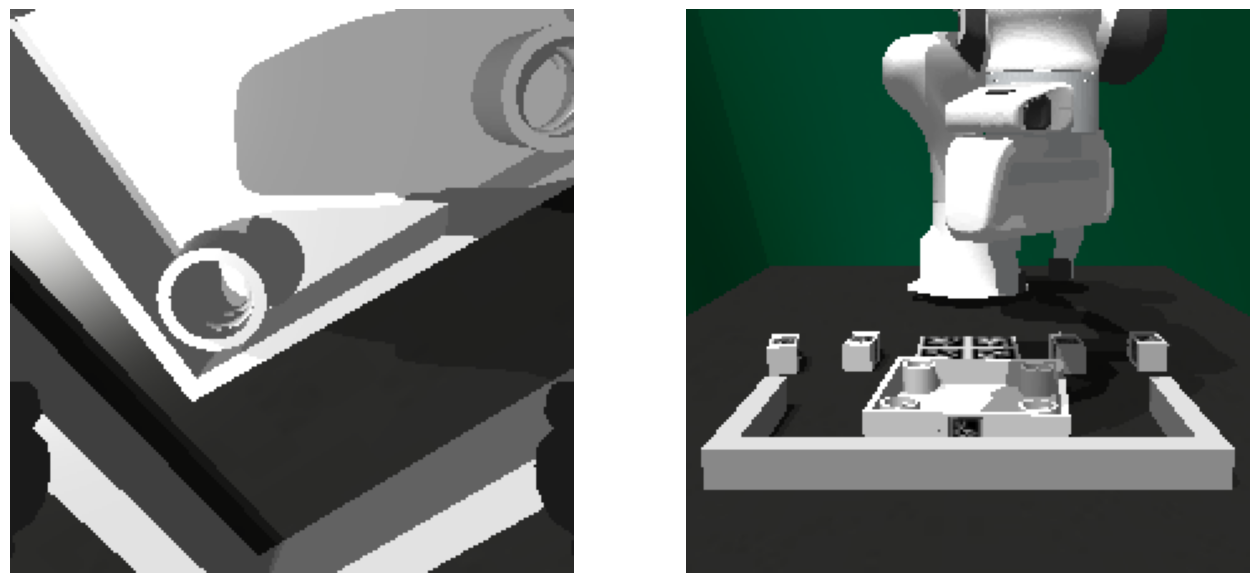

In [14]:
# config for wandb
config = dict(
    pred_horizon=16,
    obs_horizon=2,
    action_horizon=4,
    batch_size=256,
    num_epochs=100,
    num_diffusion_iters=100,
    beta_schedule="squaredcos_cap_v2",
    clip_sample=True,
    prediction_type="epsilon",
    lr=1e-4,
    weight_decay=1e-6,
    ema_power=0.75,
    lr_scheduler_type="cosine",
    lr_scheduler_warmup_steps=500,
    dataloader_workers=4,
)

# Init wandb
wandb.init(project="furniture-diffusion", entity="ankile", config=config)
config = wandb.config

dataset = OneLegStateDataset(
    dataset_path="demos.zarr",
    pred_horizon=config.pred_horizon,
    obs_horizon=config.obs_horizon,
    action_horizon=config.action_horizon,
)

# save training data statistics (min, max) for each dim
stats = dataset.stats

# create dataloader
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=config.batch_size,
    num_workers=config.dataloader_workers,
    shuffle=True,
    # accelerate cpu-gpu transfer
    pin_memory=True,
    # don't kill worker process afte each epoch
    persistent_workers=True,
)

# create network object
noise_pred_net = ConditionalUnet1D(
    input_dim=action_dim,
    global_cond_dim=obs_dim * config.obs_horizon,
).to(device)

# for this demo, we use DDPMScheduler with 100 diffusion iterations
noise_scheduler = DDPMScheduler(
    num_train_timesteps=config.num_diffusion_iters,
    # the choise of beta schedule has big impact on performance
    # we found squared cosine works the best
    beta_schedule=config.beta_schedule,
    # clip output to [-1,1] to improve stability
    clip_sample=config.clip_sample,
    # our network predicts noise (instead of denoised action)
    prediction_type=config.prediction_type,
)

wandb.watch(noise_pred_net)

# Exponential Moving Average
# accelerates training and improves stability
# holds a copy of the model weights
ema = EMAModel(parameters=noise_pred_net.parameters(), power=config.ema_power)

# AdamW optimizer
optimizer = torch.optim.AdamW(
    params=noise_pred_net.parameters(),
    lr=config.lr,
    weight_decay=config.weight_decay,
)

# Cosine LR schedule with linear warmup
lr_scheduler = get_scheduler(
    name=config.lr_scheduler_type,
    optimizer=optimizer,
    num_warmup_steps=config.lr_scheduler_warmup_steps,
    num_training_steps=len(dataloader) * config.num_epochs,
)


tglobal = tqdm(range(config.num_epochs), desc="Epoch")

# epoch loop
for epoch_idx in tglobal:
    epoch_loss = list()
    # batch loop
    with tqdm(dataloader, desc="Batch", leave=False) as tepoch:
        for nbatch in tepoch:
            # data normalized in dataset
            # device transfer
            nobs = nbatch["obs"].to(device)
            naction = nbatch["action"].to(device)
            B = nobs.shape[0]

            # observation as FiLM conditioning
            # (B, obs_horizon, obs_dim)
            obs_cond = nobs[:, : config.obs_horizon, :]
            # (B, obs_horizon * obs_dim)
            obs_cond = obs_cond.flatten(start_dim=1)

            # sample noise to add to actions
            noise = torch.randn(naction.shape, device=device)

            # sample a diffusion iteration for each data point
            timesteps = torch.randint(
                0, noise_scheduler.config.num_train_timesteps, (B,), device=device
            ).long()

            # add noise to the clean images according to the noise magnitude at each diffusion iteration
            # (this is the forward diffusion process)
            noisy_actions = noise_scheduler.add_noise(naction, noise, timesteps)

            # predict the noise residual
            noise_pred = noise_pred_net(noisy_actions, timesteps, global_cond=obs_cond)

            # L2 loss
            loss = nn.functional.mse_loss(noise_pred, noise)

            # optimize
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # step lr scheduler every batch
            # this is different from standard pytorch behavior
            wandb.log({"lr": lr_scheduler.get_last_lr()[0]})
            lr_scheduler.step()

            # update Exponential Moving Average of the model weights
            ema.step(noise_pred_net.parameters())

            # logging
            loss_cpu = loss.item()
            epoch_loss.append(loss_cpu)
            wandb.log({"batch_loss": loss_cpu})

            tepoch.set_postfix(loss=loss_cpu)
    tglobal.set_postfix(loss=np.mean(epoch_loss))
    wandb.log({"epoch_loss": np.mean(epoch_loss), "epoch": epoch_idx})

tglobal.close()
# Weights of the EMA model
# is used for inference
ema.copy_to(noise_pred_net.parameters())

# save model
torch.save(noise_pred_net.state_dict(), "noise_pred_net3.pt")

print("Done training, recording rollout")
rewards, imgs1, imgs2 = rollout(
    env,
    noise_pred_net,
    noise_scheduler,
    stats,
    config,
)

# Make a video of the rollout
filename = f"rollout-{wandb.run.name}.mp4"
render_mp4(imgs1, imgs2, filename=filename)

# Log the video to wandb
wandb.log({"rollout": wandb.Video(filename, fps=10, format="mp4")})

wandb.finish()

  0%|          | 0/502 [00:00<?, ?it/s]

100%|█████████▉| 501/502 [01:03<00:00,  7.89it/s]

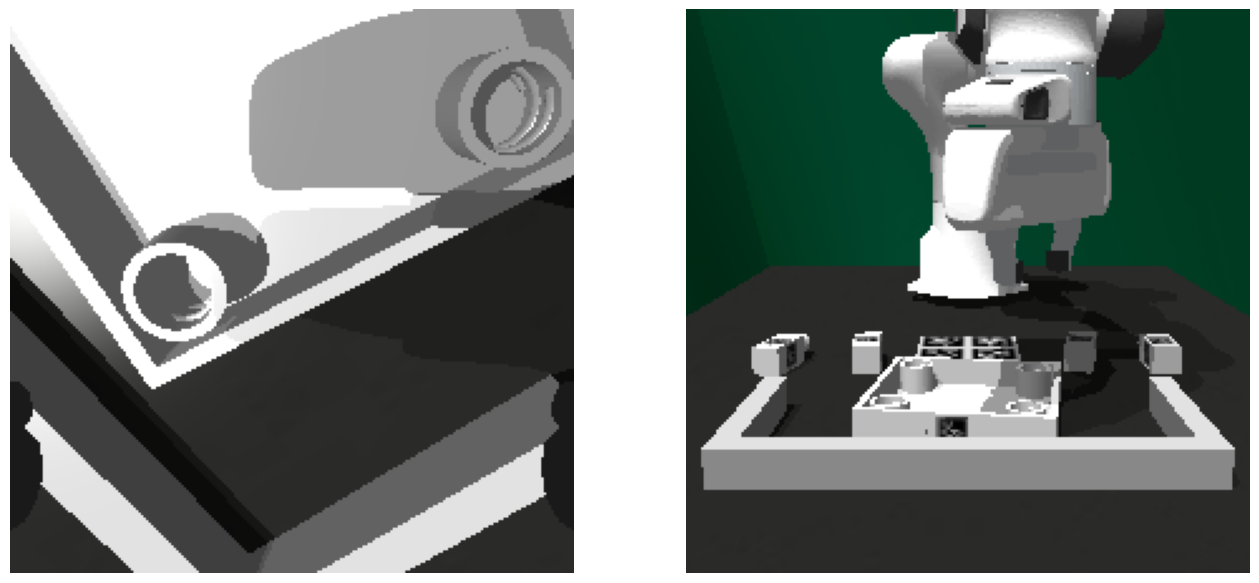

In [ ]:
render_mp4(imgs1, imgs2, filename="fourth_rollout.mp4")

In [ ]:
# visualize
from IPython.display import Video

vwrite("vis.mp4", imgs)
Video("vis.mp4", embed=True, width=256, height=256)